# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [6]:
# your code here
words = data.sort_values('Word')['Word'].unique().tolist()
words.append('ENDPAD')
n_words = len(words)


In [7]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [8]:
# your code here
tags = data.sort_values('Tag')['Tag'].unique().tolist()
tags.append('PAD')
n_tags = len(tags)

In [9]:
# Run this cell to show your results for n_tags
print(n_tags)


18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

# your code here


In [10]:
import pickle
sentence_list = None
# with open("sentence_list.pickle", "wb") as fp:   #Pickling
#     pickle.dump(sentence_list, fp)
try:    
    with open("sentence_list.pickle", "rb") as fp:   # Unpickling
        sentence_list = pickle.load(fp)
except:
    print("No Sentence List File Found")
if sentence_list == None:
    sentences = data['Sentence #'].unique().tolist()
    sentence_list = [[] for x in range(len(sentences))]
    for index, row in data.iterrows():
        sentence_number = sentences.index(row['Sentence #'])
        sentence_list[sentence_number].append((row['Word'], row['Tag']))
    with open("sentence_list.pickle", "wb") as fp:   #Pickling
        pickle.dump(sentence_list, fp)
    


In [11]:
sentence_list[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [12]:
max_len = 0
for sentence in sentence_list:
    if len(sentence) > max_len:
        max_len = len(sentence)

# Run this cell to show your results for max_len


In [13]:
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [14]:
# your code here
distinct_numbers = np.linspace(0,n_words-1,n_words, dtype=int)
word2idx = {}
idx2word = {}
for i in range(len(distinct_numbers)):
    word2idx[words[i]] = distinct_numbers[i]
    idx2word[distinct_numbers[i]] = words[i]
word2idx

{'!': 0,
 '"': 1,
 '#': 2,
 '#NAME?': 3,
 '$': 4,
 '%': 5,
 '%-plus': 6,
 '&': 7,
 "'": 8,
 "'70s": 9,
 "'80s": 10,
 "'T": 11,
 "'d": 12,
 "'ll": 13,
 "'m": 14,
 "'n": 15,
 "'re": 16,
 "'s": 17,
 "'ve": 18,
 '(': 19,
 ')': 20,
 ',': 21,
 '-': 22,
 '--': 23,
 '.': 24,
 '..': 25,
 '...': 26,
 '.tv': 27,
 '/': 28,
 '0': 29,
 '0-3': 30,
 '0-6': 31,
 '0.01': 32,
 '0.02': 33,
 '0.04': 34,
 '0.050474537': 35,
 '0.051655093': 36,
 '0.060092593': 37,
 '0.068171296': 38,
 '0.068217593': 39,
 '0.068263889': 40,
 '0.068275463': 41,
 '0.068472222': 42,
 '0.08': 43,
 '0.1': 44,
 '0.110474537': 45,
 '0.110625': 46,
 '0.12': 47,
 '0.161': 48,
 '0.17': 49,
 '0.19': 50,
 '0.193': 51,
 '0.2': 52,
 '0.3': 53,
 '0.35': 54,
 '0.4': 55,
 '0.5': 56,
 '0.55': 57,
 '0.6': 58,
 '0.65': 59,
 '0.7': 60,
 '0.8': 61,
 '0.82': 62,
 '0.9': 63,
 '01-Feb': 64,
 '01-Jan': 65,
 '01-Jun': 66,
 '02-Feb': 67,
 '02-Jan': 68,
 '02-Jun': 69,
 '02-May': 70,
 '03-Apr': 71,
 '03-Feb': 72,
 '03-Jan': 73,
 '03-Jun': 74,
 '03-Mar': 7

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [15]:
# your code here
X = [[] for x in range(len(sentence_list))]
for i in range(len(sentence_list)):
    X[i] = []
    for j in range(len(sentence_list[i])):
        (word, tag) = sentence_list[i][j]
        X[i].append( word2idx[word])


**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [16]:
# your code here
X = pad_sequences(X,max_len,value = word2idx['ENDPAD'])

In [17]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178  6283 27700 31967 25619 24853 33246 19981 25517 33246 29399
 34878 19044 18095 34971 32712 31830 17742     1  4114 11464 11631 14985
     1 17364     1 14484 33246  3881    24     1]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [18]:
# your code here
# your code here
distinct_numbers = np.linspace(0,n_tags-1,n_tags, dtype=int)
tag2idx = {}
idx2tag = {}
for i in range(len(distinct_numbers)):
    tag2idx[tags[i]] = distinct_numbers[i]
    idx2tag[distinct_numbers[i]] = tags[i]
idx2tag

{0: 'B-art',
 1: 'B-eve',
 2: 'B-geo',
 3: 'B-gpe',
 4: 'B-nat',
 5: 'B-org',
 6: 'B-per',
 7: 'B-tim',
 8: 'I-art',
 9: 'I-eve',
 10: 'I-geo',
 11: 'I-gpe',
 12: 'I-nat',
 13: 'I-org',
 14: 'I-per',
 15: 'I-tim',
 16: 'O',
 17: 'PAD'}

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [19]:
# your code here
# your code here
Y = [[] for x in range(len(sentence_list))]
for i in range(len(sentence_list)):
    Y[i] = []
    for j in range(len(sentence_list[i])):
        (word, tag) = sentence_list[i][j]
        Y[i].append( tag2idx[tag])


**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [20]:
# your # your code here
Y = pad_sequences(Y,max_len, value=tag2idx['PAD'])


**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [21]:
# your code here
Y = to_categorical(Y, num_classes = n_tags)


In [22]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [23]:
# your code here
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.1)


## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [24]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [25]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [26]:
# your code here
baseline = np.zeros((n_words,n_tags))
percent = 0
for i in range(X_tr.shape[0]):
    for j in range(X.shape[1]):
        word_id = X_tr[i,j]
        baseline[word_id,:] += y_tr[i,j,:]


new_baseline = np.zeros((n_words,1))
for i in range(n_words):
    if np.sum(baseline[i,:]) == 0:
        tag = tag2idx['O']
    else: 
        tag = np.argmax(baseline[i,:])
    new_baseline[i] = tag
baseline = np.squeeze(new_baseline)

In [27]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [28]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [29]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

max_len

104

In [30]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 16s 408us/sample - loss: 0.3146 - accuracy: 0.9786 - val_loss: 0.0599 - val_accuracy: 0.9858
Epoch 2/10
38846/38846 [==============================] - 14s 355us/sample - loss: 0.0515 - accuracy: 0.9863 - val_loss: 0.0482 - val_accuracy: 0.9868
Epoch 3/10
38846/38846 [==============================] - 14s 351us/sample - loss: 0.0451 - accuracy: 0.9872 - val_loss: 0.0456 - val_accuracy: 0.9873
Epoch 4/10
38846/38846 [==============================] - 14s 348us/sample - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.0442 - val_accuracy: 0.9877
Epoch 5/10
38846/38846 [==============================] - 14s 348us/sample - loss: 0.0415 - accuracy: 0.9881 - val_loss: 0.0434 - val_accuracy: 0.9879
Epoch 6/10
38846/38846 [==============================] - 14s 352us/sample - loss: 0.0406 - accuracy: 0.9883 - val_loss: 0.0430 - val_accuracy: 0.9881
Epoch 7/10
38846/38846 [=====================

In [32]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


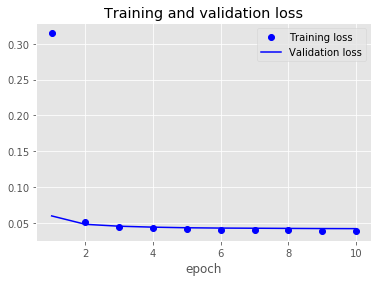

In [33]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

The embedding layer is what converts of list of words to vectors, reducing the dimensionality of that list. In this case, we have an input dimension (meaning the number of total words) of 35179 and an input len of 104. We aim to reduce this into a 50 x 104 space. 

The embedding layer is necessary simply to reduce the dimensionality of our model and make it faster and more efficient. Moreover, the 35179 x space assumes integer values, but our weights will be floats, thus making it more efficient to reduce it to a 0-50 space.


**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

There are 35179 words in our original set and we want to reduce this to 50, so there are 1758950*50 params, as each word is thus reduced to a length 50 vector.



### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [38]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9428842240665499


In [39]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

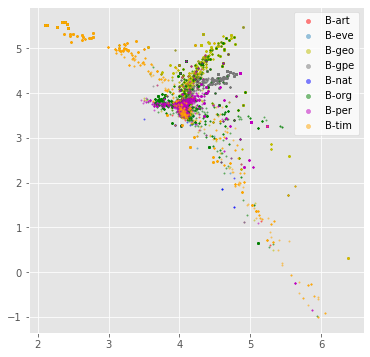

In [40]:
visualize_hidden_features(pca_result)


### Full function for other questions ###

In [41]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [42]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.942885431307113


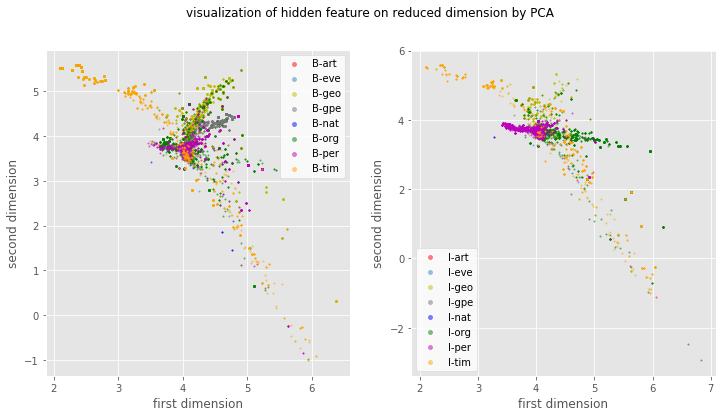

In [43]:
h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [44]:

# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(max_len,)))
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(SimpleRNN(units = n_units, return_sequences=True,))
model.add(TimeDistributed(tf.keras.layers.Dense(n_tags, activation='softmax')))



# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 78s 2ms/sample - loss: 0.0869 - accuracy: 0.9773 - val_loss: 0.0352 - val_accuracy: 0.9895
Epoch 2/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0298 - accuracy: 0.9911 - val_loss: 0.0290 - val_accuracy: 0.9913
Epoch 3/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.0282 - val_accuracy: 0.9914
Epoch 4/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0247 - accuracy: 0.9926 - val_loss: 0.0270 - val_accuracy: 0.9919
Epoch 5/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.0277 - val_accuracy: 0.9916
Epoch 6/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0226 - accuracy: 0.9932 - val_loss: 0.0267 - val_accuracy: 0.9920
Epoch 7/10
38846/38846 [==============================] -

In [45]:
# save your mode #
store_keras_model(model, 'model_RNN')




Saved model to disk


In [46]:
# run this cell to show your results #
print(model.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 100)          15100     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


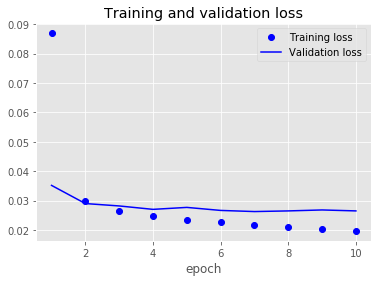

In [47]:
# run this cell to show your results #

plot_training_history(history)

 


**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.7314864797682286


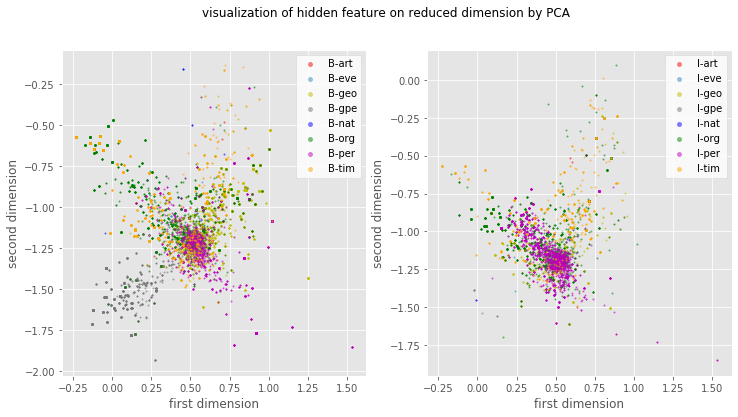

In [48]:
# your code here
h = get_hidden_output_PCA(model,X_te,y_te,1,50)
visualize_B_I(h)

The clustering of the tags within the hidden layer is incredibly inconsistent from tag to tag, and moreover, the difference in the number of instances of a given tag mean that some tags are much easier to see than others (e.g. B-org, B-per, I-per).Interestingly, the percent of the total variance explained by the first two components of PCA is significantly lower than our FFNN model (~90% to & 75%)

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

*your answer here*
A GRU attempts to remedy the issue that simple RNNs have with short-term memory -- if input is long, the entirety of a given sentence sometimes does not affect the outcome for a given word. However, instead of passing all information at a given state to the next state, a GRU introduces two new tages, an Update Gate, which decides what information to pass to the next step, and a Reset gate, which also determines how much past information to forget. BY adding these two gates, we can thus pack-propagation to determine which information is important to pass forward in a RNN and which is ok to throw out, significantly improving out performance.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [49]:
# your code here

# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(max_len,)))
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(GRU(units = n_units, return_sequences=True,))
model.add(TimeDistributed(tf.keras.layers.Dense(n_tags, activation='softmax')))


    
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 42s 1ms/sample - loss: 0.0886 - accuracy: 0.9785 - val_loss: 0.0336 - val_accuracy: 0.9901
Epoch 2/10
38846/38846 [==============================] - 37s 965us/sample - loss: 0.0292 - accuracy: 0.9913 - val_loss: 0.0286 - val_accuracy: 0.9914
Epoch 3/10
38846/38846 [==============================] - 37s 962us/sample - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.0274 - val_accuracy: 0.9918
Epoch 4/10
38846/38846 [==============================] - 37s 964us/sample - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0266 - val_accuracy: 0.9921
Epoch 5/10
38846/38846 [==============================] - 37s 959us/sample - loss: 0.0228 - accuracy: 0.9931 - val_loss: 0.0262 - val_accuracy: 0.9920
Epoch 6/10
38846/38846 [==============================] - 37s 962us/sample - loss: 0.0218 - accuracy: 0.9934 - val_loss: 0.0258 - val_accuracy: 0.9922
Epoch 7/10
38846/38846 [=======================

In [50]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [51]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


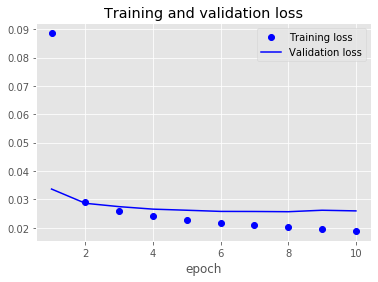

In [52]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.8130815147157151


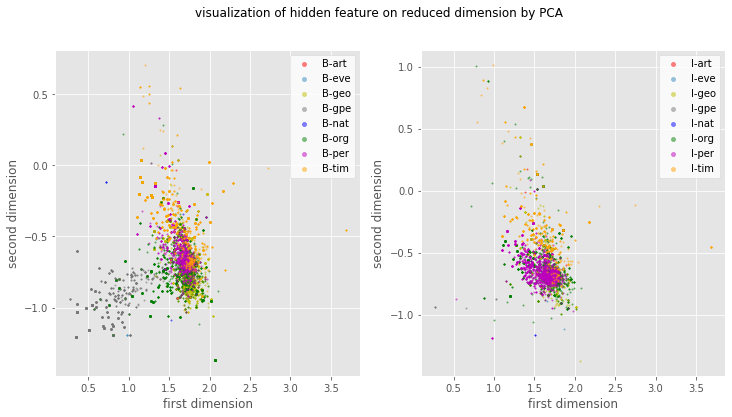

In [53]:
# your code here
h = get_hidden_output_PCA(model,X_te,y_te,1,50)
visualize_B_I(h)

As indicated above, the GRU does a much better job of clustering our tags than our Naive RNN, and it explains almost 10% more of the variance in the data. While this is still less than our Naive model, it should be noted that that model was not taking into account the context of a word in a sentence, and thus is providing much worse predictions, especially for words that may differ on their classification given their context or usage. 

Again, it should be noted that we have significantly more instances of some tags than others, and it is thus harder to observe the performance of our model at identifying these tags from the graph. This may be an issue as we attempt to classify words to these sparse tags.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



While a standard GRU improves the performance of a RNN by learning which information is important to pass forward and which can be forgotten, it suffers from an obvious issue, that it is still only passing things forwards, and thus, if important information about the context of a word occurs after that word in a sentence, we are not training the model to pick up this information. Thus, a  BiDirectional GRU, by more or less training two layers, on both the forward and backwards read on a sentence, creates a system by which we are able to pass information forwards and backwards, thus improving the performance of our model..

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [54]:
# your code here
# your code here

# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(max_len,)))

model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(Bidirectional(GRU(units = n_units, return_sequences=True,)))
model.add(TimeDistributed(tf.keras.layers.Dense(n_tags, activation='softmax')))



# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0730 - accuracy: 0.9817 - val_loss: 0.0293 - val_accuracy: 0.9915
Epoch 2/10
38846/38846 [==============================] - 70s 2ms/sample - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0244 - val_accuracy: 0.9928
Epoch 3/10
38846/38846 [==============================] - 70s 2ms/sample - loss: 0.0210 - accuracy: 0.9938 - val_loss: 0.0233 - val_accuracy: 0.9931
Epoch 4/10
38846/38846 [==============================] - 70s 2ms/sample - loss: 0.0192 - accuracy: 0.9943 - val_loss: 0.0222 - val_accuracy: 0.9934
Epoch 5/10
38846/38846 [==============================] - 70s 2ms/sample - loss: 0.0178 - accuracy: 0.9947 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 6/10
38846/38846 [==============================] - 70s 2ms/sample - loss: 0.0167 - accuracy: 0.9950 - val_loss: 0.0217 - val_accuracy: 0.9936
Epoch 7/10
38846/38846 [==============================] -

In [55]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [56]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


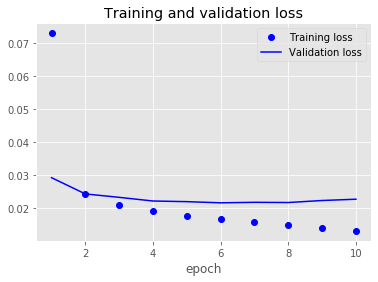

In [57]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.8233084879889284


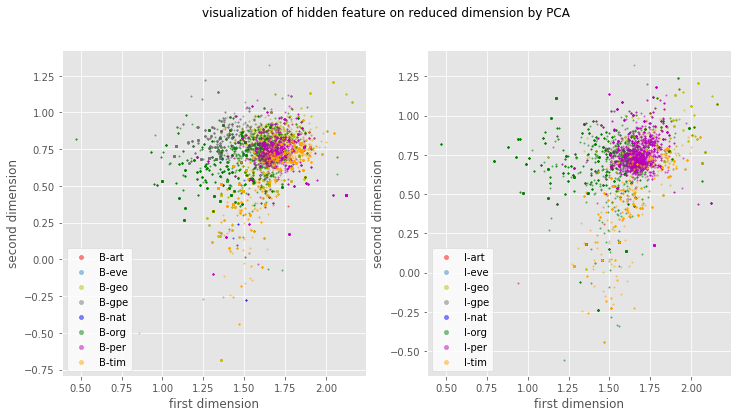

In [58]:
# your code here
h = get_hidden_output_PCA(model,X_te,y_te,1,50)
visualize_B_I(h)

The clustering above, while good, is not nearly as tight as the standard GRU. This may be because the bi-directionality has added a lot of ambiguity to tagging decisions. However, the actual performance of the model is actually better if I look at the loss and validation performance. I suppose at the end of day, there is a lot of ambiguity with word classification given the context of that word in a sentence, and as such, it is very difficult for a model to be accurate and representative of human language as a whole while also understanding the complexities and nuances of language as a whole. 

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [59]:

models = ['model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU']
f1_scores = {}
predictions = {}
baseline_pred = []
for row in X_te:
    baseline_pred.append(baseline[row])
baseline_pred = np.array(baseline_pred)
predictions['baseline'] = baseline_pred
y_te_flat = np.argmax(y_te, axis=2)
predictions['y_true'] = y_te_flat
f1_scores['baseline'] = f1_score(y_te_flat.reshape(-1), baseline_pred.reshape(-1), average=None)
for model_name in models:
    model = load_keras_model(model_name)
    y_pred = model.predict_classes(X_te)
    predictions[model_name] = y_pred
    f1 = f1_score(y_te_flat.reshape(-1), y_pred.reshape(-1), average=None)
    f1_scores[model_name] = f1

#     print(y_pred)
    
    

In [60]:
f1_scores

{'baseline': array([0.17777778, 0.16666667, 0.82590892, 0.9389904 , 0.07692308,
        0.59098787, 0.71042714, 0.82625684, 0.        , 0.16666667,
        0.67155425, 0.4137931 , 0.        , 0.6199794 , 0.70436695,
        0.20971867, 0.98528105, 1.        ]),
 'model_FFNN': array([0.0625    , 0.1875    , 0.81626964, 0.92564587, 0.35      ,
        0.57117853, 0.69518356, 0.80862534, 0.        , 0.0952381 ,
        0.64296754, 0.42857143, 0.        , 0.59744991, 0.6954933 ,
        0.21292776, 0.98207806, 1.        ]),
 'model_RNN': array([0.        , 0.21428571, 0.85333333, 0.93963908, 0.27586207,
        0.66537181, 0.82010749, 0.86297689, 0.        , 0.09090909,
        0.77506775, 0.52173913, 0.28571429, 0.7778126 , 0.86220124,
        0.71813953, 0.98917109, 1.        ]),
 'model_GRU': array([0.        , 0.21428571, 0.85945475, 0.94128611, 0.26666667,
        0.66442011, 0.82075472, 0.86345488, 0.        , 0.07692308,
        0.78929766, 0.52173913, 0.5       , 0.78062678, 0.8673

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

dict_keys(['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O', 'PAD'])

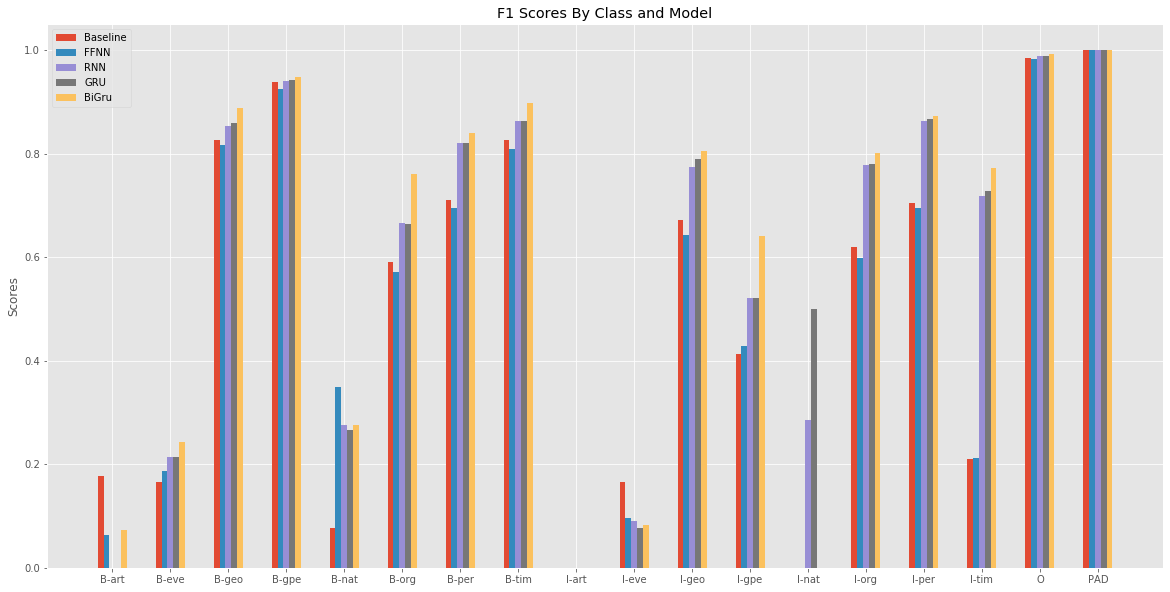

In [61]:
# ['model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU']
model_RNN = f1_scores['model_RNN']


ind = np.arange(18)  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects0 = ax.bar(ind - 2*width, f1_scores['baseline'], width,
                label='Baseline')
rects1 = ax.bar(ind - width, f1_scores['model_FFNN'], width,
                label='FFNN')
rects2 = ax.bar(ind , f1_scores['model_RNN'], width,
                label='RNN')
rects3 = ax.bar(ind + width, f1_scores['model_GRU'], width,
                label='GRU')
rects4 = ax.bar(ind + 2*width, f1_scores['model_BiGRU'], width,
                label='BiGru')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('F1 Scores By Class and Model')
ax.set_xticks(ind)
ax.set_xticklabels((tag2idx.keys()))
ax.legend()
tag2idx.keys()

**3.3** Briefly discuss the performance of each model

As predicted in the earlier analyses sections, the does the best across the board.This improvement is mostly seen by the tags with the lowest occurrence in the dataset. Generally, the performance of the models vary significantly from tag to tag, with a score of nearly 1 for the highest incidence tags and 0s across the board for I-art, which is very infrequent. Interestingly, the basline model outperformed the FFNN in many situations, demonstrating the need for RNNs when analyzing words within sentences. Generally, as we added gates to our RNN (GRU -> BiGRU), our performance increased. However, it should be noted that this also added to the training time of the model, as the number of params being trained on is also increasing. 

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

*your answer here*
The tags with the worst performance across the board were the Art, Eve, and Nat tags (both B and I) 

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [62]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [63]:
# your code herepredictions
# for row in range(np.shape(y_te))
models = ['baseline','model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU']

y_te_flat.shape
max_diff = 0
max_diff_index = 0
for i in range(y_te_flat.shape[0]):
    this_diff = 0
    for model_name in models:
        for j in range (y_te_flat.shape[1]):
            if y_te_flat[i,j] != predictions[model_name][i,j]:
                this_diff += 1
    if this_diff > max_diff:
        print("Max", i)
        max_diff = this_diff
        max_diff_index = i

print("The sentence with the most wrong predictions is", max_diff_index)

Max 1
Max 3
Max 6
Max 50
Max 129
The sentence with the most wrong predictions is 129


In [64]:
# your code here
# id2wor
sentence_ids = X_te[50,:].tolist()

sentence = []
for word_id in sentence_ids: 
    sentence.append(idx2word[word_id])
    
sentence[35:]
sentence_df = pd.DataFrame()
models.insert(0, 'y_true')
sentence_df['Word'] = sentence[50:]
for model_name in models:
    preds = predictions[model_name][50,:]
    pred_tags = []
    for i in range(len(preds)):
        pred_tags.append(idx2tag[preds[i]])
    sentence_df[model_name] = pred_tags[50:]
sentence_df.style.apply(highlight_errors, axis=1)

,Word,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,Wednesday,B-tim,B-tim,B-tim,B-tim,B-tim,B-tim
1,'s,O,O,O,O,O,O
2,statement,O,O,O,O,O,O
3,also,O,O,O,O,O,O
4,called,O,O,O,O,O,O
5,on,O,O,O,O,O,O
6,all,O,O,O,O,O,O
7,Ethiopian,B-gpe,B-gpe,B-gpe,B-gpe,B-gpe,B-gpe
8,political,O,O,O,O,O,O
9,parties,O,O,O,O,O,O


In [61]:
# your code here


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [66]:
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(y_tr, axis=2).flatten()
np.unique(y_integers)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights
for i in range(len(class_weights)):
    print("ID: ", i, "Tag:", idx2tag[i], "Weight in Dataset:",class_weights[i])

class_weights

ID:  0 Tag: B-art Weight in Dataset: 670.3930704898447
ID:  1 Tag: B-eve Weight in Dataset: 881.2234000785238
ID:  2 Tag: B-geo Weight in Dataset: 7.375235766907855
ID:  3 Tag: B-gpe Weight in Dataset: 17.50570140546274
ID:  4 Tag: B-nat Weight in Dataset: 1385.479012345679
ID:  5 Tag: B-org Weight in Dataset: 13.711580284925347
ID:  6 Tag: B-per Weight in Dataset: 16.258310334586493
ID:  7 Tag: B-tim Weight in Dataset: 13.609813480802348
ID:  8 Tag: I-art Weight in Dataset: 920.2443624436245
ID:  9 Tag: I-eve Weight in Dataset: 1065.7530864197531
ID:  10 Tag: I-geo Weight in Dataset: 37.41167450078341
ID:  11 Tag: I-gpe Weight in Dataset: 1377.8244321669736
ID:  12 Tag: I-nat Weight in Dataset: 5541.916049382716
ID:  13 Tag: I-org Weight in Dataset: 16.466571292322364
ID:  14 Tag: I-per Weight in Dataset: 16.033574786050032
ID:  15 Tag: I-tim Weight in Dataset: 42.34061497830598
ID:  16 Tag: O Weight in Dataset: 0.3122339132084774
ID:  17 Tag: PAD Weight in Dataset: 0.0703387225687017

array([6.70393070e+02, 8.81223400e+02, 7.37523577e+00, 1.75057014e+01,
       1.38547901e+03, 1.37115803e+01, 1.62583103e+01, 1.36098135e+01,
       9.20244362e+02, 1.06575309e+03, 3.74116745e+01, 1.37782443e+03,
       5.54191605e+03, 1.64665713e+01, 1.60335748e+01, 4.23406150e+01,
       3.12233913e-01, 7.03387226e-02])

As evidenced above by the classes with disproportionate weights above, some classes are WAY more represented in our dataset than others, and those datasets seem to be the ones for which I'm performing worse. I'll pass these weights to keras so when it trains, it values instances of that class more than others.  

In [70]:
# your code here

n_units = 100
drop_rate = .3
dim_embed = 50
class_weights = class_weights

optimizer = "adam"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(max_len,)))

model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(Bidirectional(GRU(units = n_units, return_sequences=True,)))
model.add(TimeDistributed(tf.keras.layers.Dense(n_tags, activation='softmax')))



# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# class_weights[[0,1,4,8,9,12]]  = 400
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, class_weight=class_weights)
# y_pred = model.predict_classes(X_te)
# f1 = f1_score(y_te_flat.reshape(-1), y_pred.reshape(-1), average=None)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 78s 2ms/sample - loss: 0.1131 - accuracy: 0.9754 - val_loss: 0.0297 - val_accuracy: 0.9916
Epoch 2/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0238 - accuracy: 0.9930 - val_loss: 0.0235 - val_accuracy: 0.9930
Epoch 3/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.0222 - val_accuracy: 0.9934
Epoch 4/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0157 - accuracy: 0.9950 - val_loss: 0.0218 - val_accuracy: 0.9934
Epoch 5/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0219 - val_accuracy: 0.9935
Epoch 6/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0126 - accuracy: 0.9959 - val_loss: 0.0224 - val_accuracy: 0.9935
Epoch 7/10
38846/38846 [==============================] -

Saved model to disk


dict_keys(['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O', 'PAD'])

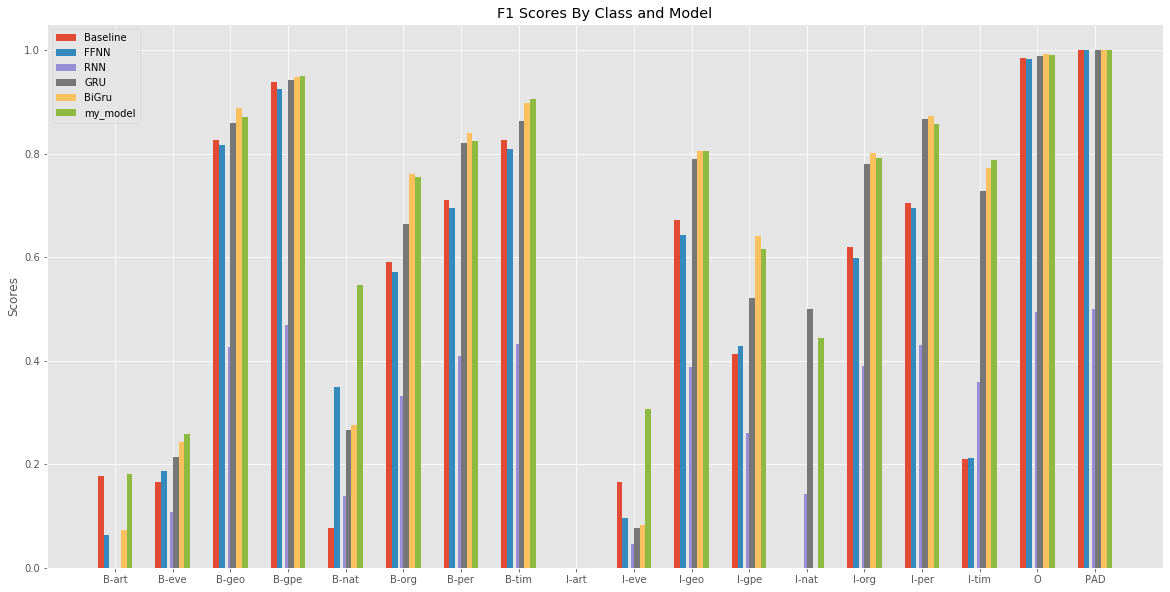

In [71]:
y_pred = model.predict_classes(X_te)
f1 = f1_score(y_te_flat.reshape(-1), y_pred.reshape(-1), average=None)
f1_scores['my_model'] = f1
store_keras_model(model, 'my_model')
models = ['baseline','model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU', 'my_model']

ind = np.arange(18)  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects0 = ax.bar(ind - (5/2)*width, f1_scores['baseline'], width,
                label='Baseline')
rects1 = ax.bar(ind - (3/2)*width, f1_scores['model_FFNN'], width,
                label='FFNN')
rects2 = ax.bar(ind , (1/2)*f1_scores['model_RNN'], width,
                label='RNN')
rects3 = ax.bar(ind + (1/2)*width, f1_scores['model_GRU'], width,
                label='GRU')
rects4 = ax.bar(ind + (3/2)*width, f1_scores['model_BiGRU'], width,
                label='BiGru')
rects4 = ax.bar(ind + (5/2)*width, f1_scores['my_model'], width,
                label='my_model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('F1 Scores By Class and Model')
ax.set_xticks(ind)
ax.set_xticklabels((tag2idx.keys()))
ax.legend()
tag2idx.keys()

While I was able to improver performance (as indicated above) by changing the class weights, I'll try augmenting my dataset by duplicating entities with rare tags in it.

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

Given it generally performed the best across the board, I decided to improve the BiGru.


I was able to achieve the greatest success improving my model via data modification. Initially, I tried duplicating rows in my Train DF which contained underrepresented tags. This was pretty hacky, however, and i eventually chose to simple use the class_weight param in keras model.fit, which allows you to weight instances of certain classes differently. I took advantage of the SKLearn compute_class_weights model, which analyses the occurrence of tags within a dataset and assigns weights so that the rarer tags are more imporant that the most common ones. I applied "the balanced" param, which thus calculated weights for each class such that the weights * occurrence of those tags is constant (Thus the most infrequent tags had the highest weights). 

I tried to increase the number of nodes in the BiGru layer, but this did not improve performance significantly. 

I believe I could have achieved better performance by handpicking the the specific rows that were duplicated. Additionally, perhaps I could improve the performance of the model by adding more layers, and potentially creating a Deep RNN, though, again, this increases the computational overhead.